# Load the clean dataset

In [1]:
import numpy as np
from py.train import train_mnist, test
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from algo.variable_optim import VSGD
from py.nets import Conv1
from py.utils import get_default_device, download_url
from py.train import train_mnist, test
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from py import ce
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os

learning_rate = 0.01
momentum = 0.9
batch_size = 64
var = 0.01

url = "https://zenodo.org/record/3239543/files/mnist_c.zip"
target_path = "./datasets/mnist_c.zip"

# Download the MNIST dataset

In [2]:
if (os.path.exists("./datasets/mnist_c/") != True):
    download_url(url, target_path)
    import zipfile
    with zipfile.ZipFile(target_path, 'r') as zip_ref:
        zip_ref.extractall("./datasets/")
        #os.remove(target_path)

# Prepare the data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
            ])

class customDataset(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        # MNIST-C npy files stored with shape [10000, 28, 28, 1] as opposed to PyTorch's [10000, 1, 28, 28]
        self.xs = torch.from_numpy(np.transpose(np.load(x_path), [0, 3, 1, 2])  / 255).type('torch.FloatTensor')
        self.ys = torch.from_numpy(np.load(y_path))
        self.transform = transform
        
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]        
    
transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])

train_data = datasets.MNIST('./datasets', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_set = datasets.MNIST('./datasets', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 


# Load the corruptions

In [4]:
# 15 Corruptions which make up the MNIST-C dataset to be used for out-of-distribution testing

CORRUPTIONS = ['identity',
                'shot_noise',
                'impulse_noise',
                'glass_blur',
                'motion_blur',
                'shear',
                'scale',
                'rotate',
                'brightness',
                'translate',
                'stripe',
                'fog',
                'spatter',
                'dotted_line',
                'zigzag',
                'canny_edges',]

corrupted_mnist_datasets = dict()

for c in CORRUPTIONS:
    x_path_test = f"./datasets/mnist_c/{c}/test_images.npy"
    y_path_test = f"./datasets/mnist_c/{c}/test_labels.npy"
    ds = customDataset(x_path_test, y_path_test, transform=transform)
    corrupted_mnist_datasets[c] = ds

# Display corruptions

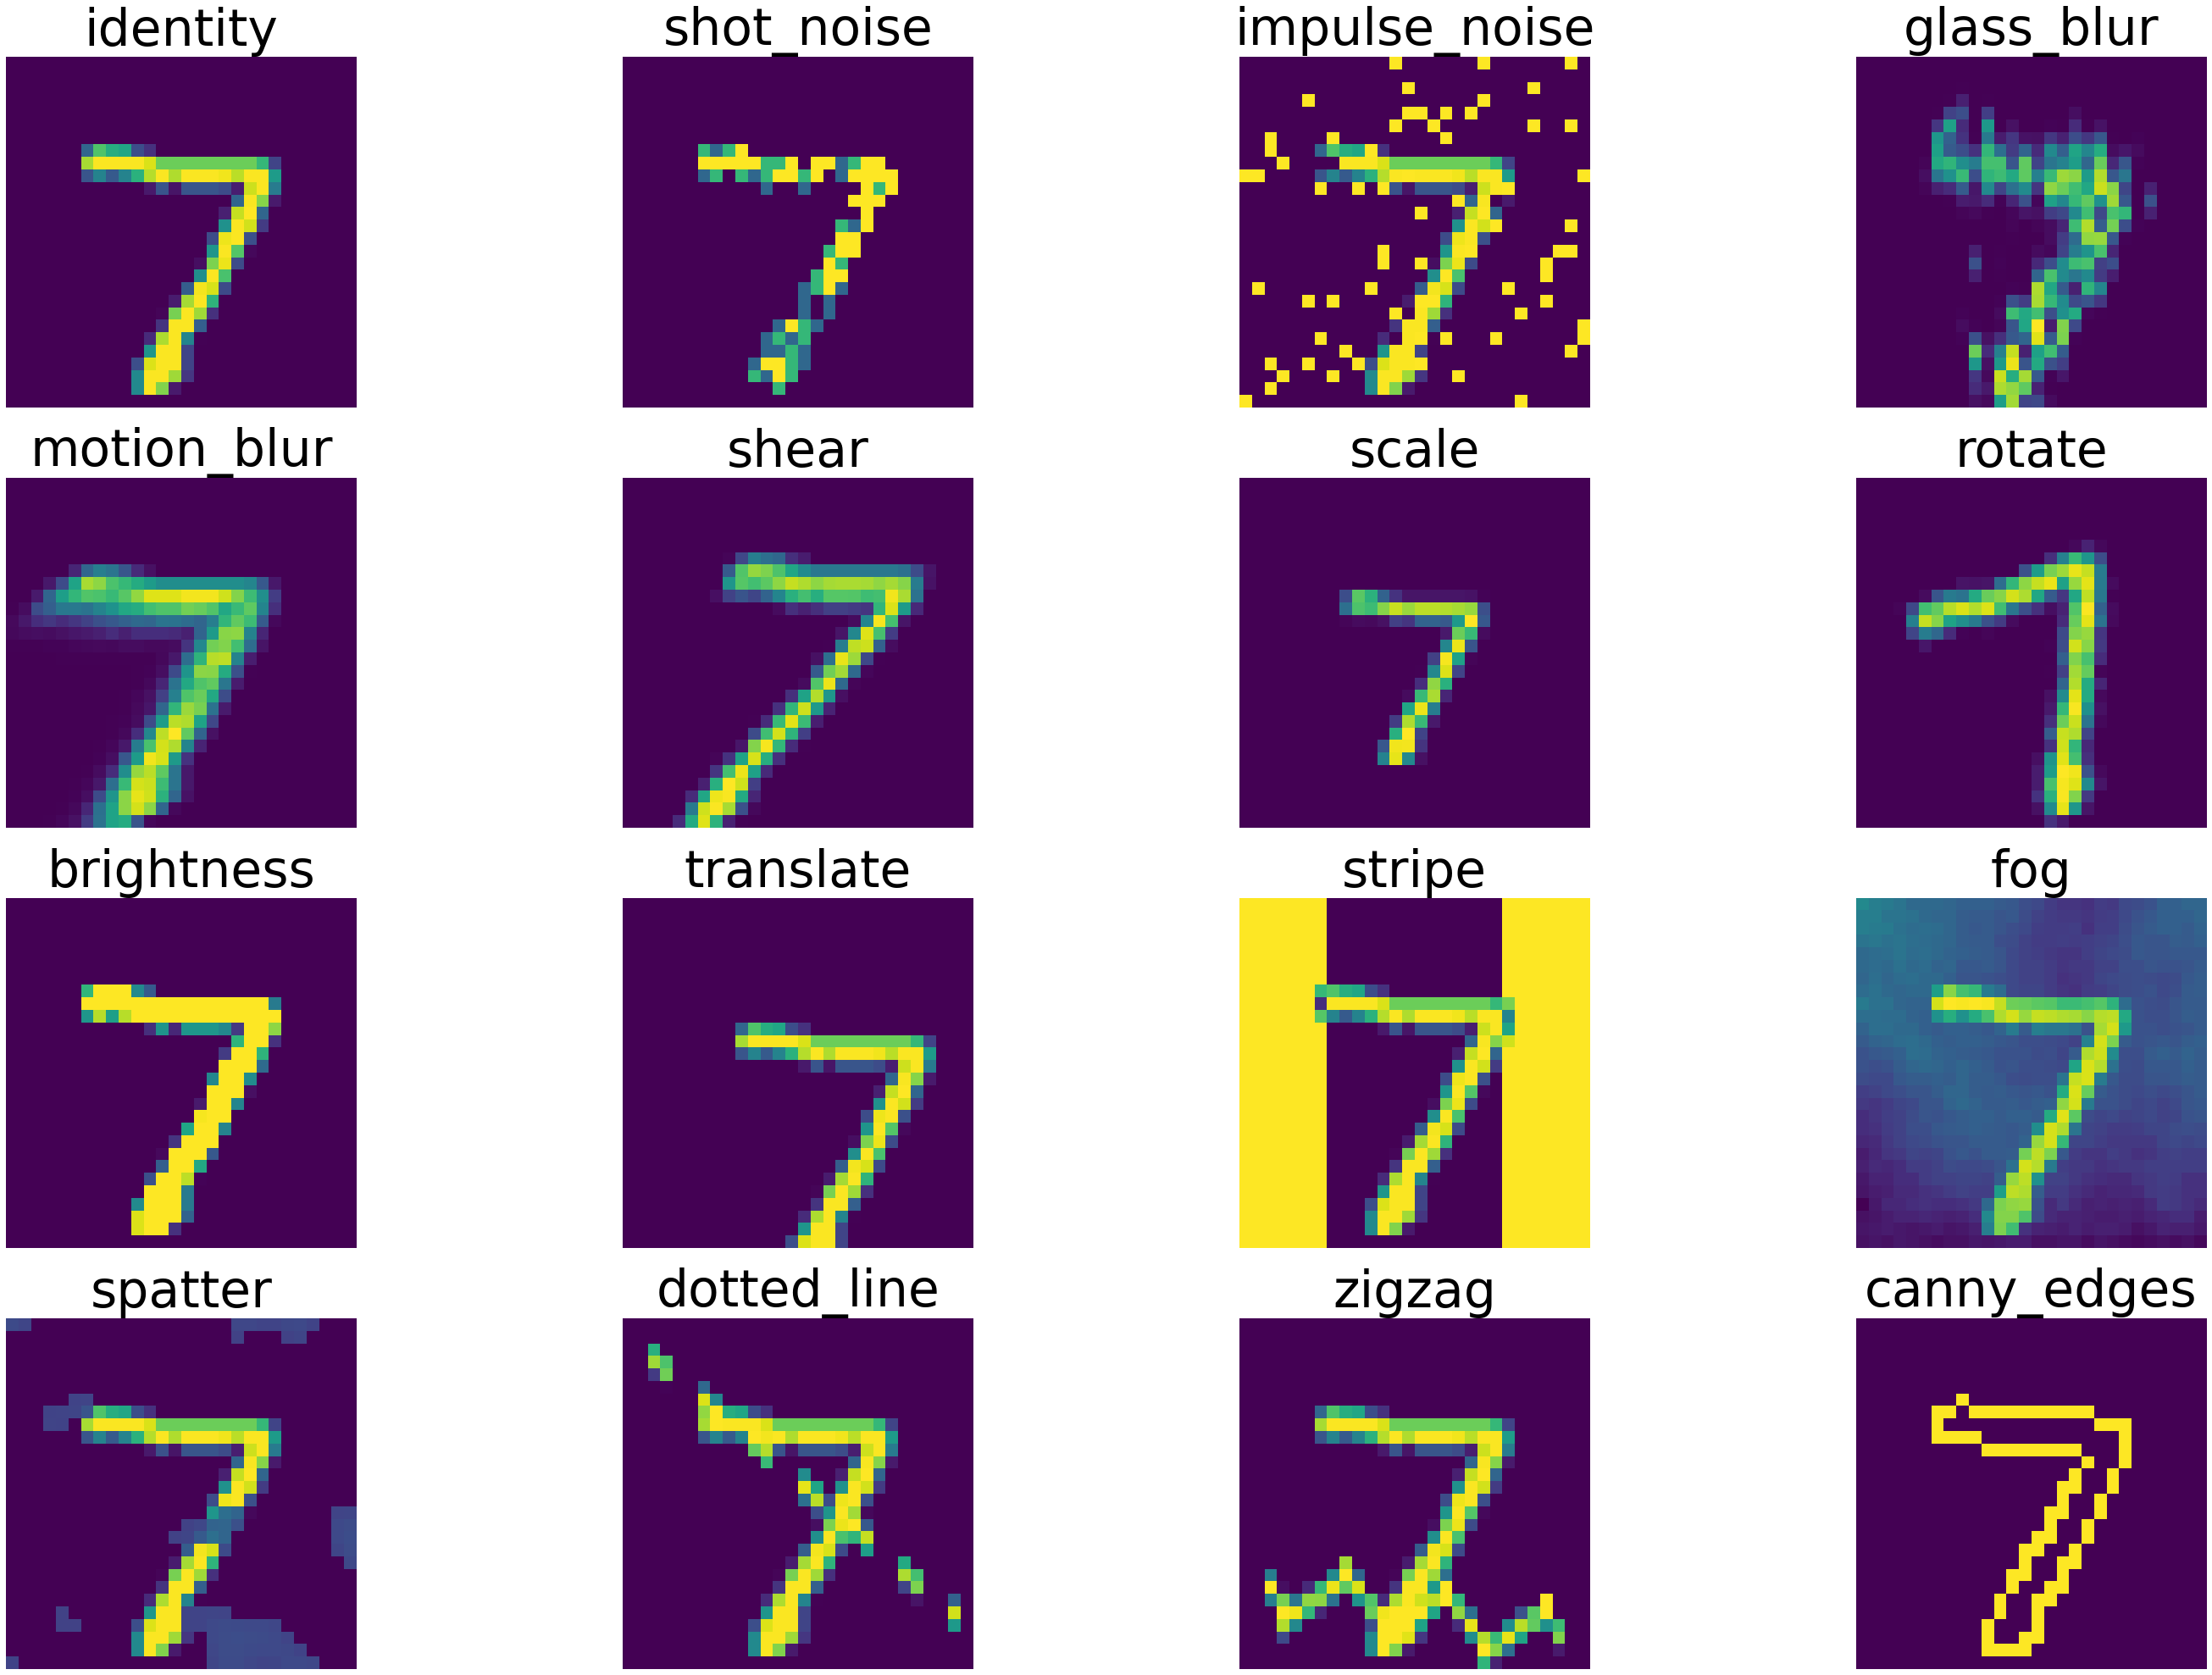

In [5]:
# create figure
fig = plt.figure(figsize=(50, 35))

rows = 4
columns = 4

for i, corruption in enumerate(CORRUPTIONS):
    #print(i)
    #print(corruption)
    img, label = corrupted_mnist_datasets[corruption][0]
    fig.add_subplot(rows, columns, i+1)
          
    # showing image
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(corruption, fontsize=60)

# Train the base model algorithm

In [6]:
device = get_default_device()
print(device)
base_model = Conv1()
base_model.to(device)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(base_model.parameters(), lr=learning_rate)

log_interval = 10
n_epochs = 3

train_losses = []
train_counter = []

test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

print("Training SGD algorithm")
train_losses, train_counter = train_mnist(base_model, optim, criterion, train_loader, device, batch_size=batch_size)

acc = test(base_model, test_loader, device, classes)

#MODEL_SAVE_DIR = "./models/sgd_mnist_model.pt"
#print("Saving model weights for SGD algorithm at: " + MODEL_SAVE_DIR)
#torch.save(base_model.state_dict(), MODEL_SAVE_DIR)

cuda
Training SGD algorithm


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Train the VSGD Algorithm

In [7]:
### PREPARING VSGD MODEL ###

v_model = Conv1()
v_model.to(device)
v_optim = VSGD(v_model.parameters(), variability=var, lr=learning_rate, momentum=momentum)

print(f"Training VSGD algorithm with var {var}")
v_train_losses, v_train_counter = train_mnist(v_model, v_optim, criterion, train_loader, device, batch_size=batch_size)


#V_MODEL_SAVE_DIR = "./models/vsgd_mnist_model.pt"
#print("Saving model weights for VSGD algorithm at: " + V_MODEL_SAVE_DIR)
#torch.save(v_model.state_dict(), V_MODEL_SAVE_DIR)

Training VSGD algorithm with var 0.01


  0%|          | 0/2814 [00:00<?, ?it/s]

# Plot the training data

Saving training loss plot at: ./plots/mnist_training.png


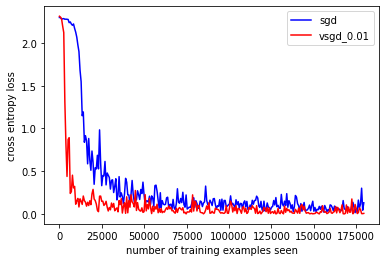

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_dir = './plots' 
plt.plot(train_counter, train_losses, color='blue', label="sgd")
plt.plot(v_train_counter, v_train_losses, color='red', label=f"vsgd_{var}")
plt.legend(loc="upper right")
plt.xlabel('number of training examples seen')
plt.ylabel('cross entropy loss')
plt.savefig(plot_dir + "/mnist_training", dpi=300, bbox_inches='tight')
print("Saving training loss plot at: " + plot_dir + "/mnist_training.png")
plt.show()

# Test the base model

In [9]:
acc = test(base_model, test_loader, device, classes, show_class_accs=True)
print(f"Standard accuracy: {acc}")

  0%|          | 0/10 [00:00<?, ?it/s]

	Accuracy for class: 0 is 98.1 %
	Accuracy for class: 1 is 97.7 %
	Accuracy for class: 2 is 99.0 %
	Accuracy for class: 3 is 98.4 %
	Accuracy for class: 4 is 94.2 %
	Accuracy for class: 5 is 98.2 %
	Accuracy for class: 6 is 97.8 %
	Accuracy for class: 7 is 92.4 %
	Accuracy for class: 8 is 97.6 %
	Accuracy for class: 9 is 97.8 %
Standard accuracy: 97.12


# Test the VSGD model

In [10]:
acc = test(v_model, test_loader, device, classes, show_class_accs=True)
print(f"Standard accuracy: {acc}")

  0%|          | 0/10 [00:00<?, ?it/s]

	Accuracy for class: 0 is 99.6 %
	Accuracy for class: 1 is 99.1 %
	Accuracy for class: 2 is 99.8 %
	Accuracy for class: 3 is 98.9 %
	Accuracy for class: 4 is 99.0 %
	Accuracy for class: 5 is 99.2 %
	Accuracy for class: 6 is 98.6 %
	Accuracy for class: 7 is 98.8 %
	Accuracy for class: 8 is 98.5 %
	Accuracy for class: 9 is 98.4 %
Standard accuracy: 99.0


# Calculate error on corruption set

In [11]:
from py import ce

base_errors = ce.corruption_errors(base_model, corrupted_mnist_datasets, device)
vsgd_errors = ce.corruption_errors(v_model, corrupted_mnist_datasets, device)

import pprint
print("Base Model errrors:")
pprint.pprint(base_errors)
print("VSGD Model errors:")
pprint.pprint(vsgd_errors)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Base Model errrors:
{'brightness': 67.19000000000001,
 'canny_edges': 58.32000000000001,
 'dotted_line': 14.85,
 'fog': 80.66,
 'glass_blur': 26.85,
 'identity': 6.5,
 'impulse_noise': 24.97,
 'motion_blur': 31.919999999999998,
 'rotate': 22.82,
 'scale': 18.07,
 'shear': 14.56,
 'shot_noise': 13.120000000000001,
 'spatter': 13.68,
 'stripe': 43.5,
 'translate': 68.82000000000001,
 'zigzag': 24.05}
VSGD Model errors:
{'brightness': 14.940000000000001,
 'canny_edges': 34.63,
 'dotted_line': 6.0600000000000005,
 'fog': 29.060000000000002,
 'glass_blur': 13.36,
 'identity': 1.43,
 'impulse_noise': 11.85,
 'motion_blur': 14.82,
 'rotate': 9.93,
 'scale': 8.17,
 'shear': 3.9600000000000004,
 'shot_noise': 4.75,
 'spatter': 4.91,
 'stripe': 8.14,
 'translate': 50.54,
 'zigzag': 15.76}


# Plot errors on different corruptions

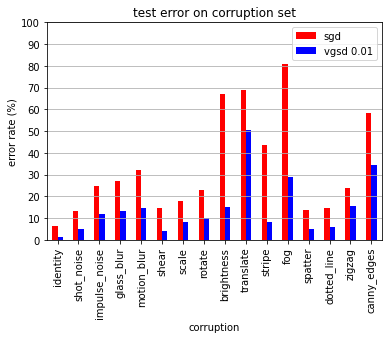

In [12]:
d = {
    'sgd': base_errors,
    'vgsd 0.01': vsgd_errors
}

ax = pd.DataFrame(d).plot(kind='bar', color=['r', 'b'])
plt.ylabel('error rate (%)')
plt.xlabel('corruption')
plt.yticks(np.linspace(0, 100, 11))
plt.grid(axis='y')
plt.title("test error on corruption set")
plt.savefig('./plots/mnist_corruption_errors.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate Corruption Errors (eq 3.1)

In [13]:
corruption_errors = {k: (vsgd_errors[k]/base_errors[k]) * 100 for k in vsgd_errors.keys() & base_errors}
print("Corruption errors:")
pprint.pprint(corruption_errors)
mce = ce.mean_corruption_error(corruption_errors)
print(f"\nMean corruption error: {mce}")

Corruption errors:
{'brightness': 22.235451704122635,
 'canny_edges': 59.37928669410151,
 'dotted_line': 40.80808080808081,
 'fog': 36.02777089015621,
 'glass_blur': 49.757914338919925,
 'identity': 22.0,
 'impulse_noise': 47.4569483380056,
 'motion_blur': 46.42857142857143,
 'rotate': 43.51446099912357,
 'scale': 45.213060320973995,
 'shear': 27.1978021978022,
 'shot_noise': 36.204268292682926,
 'spatter': 35.89181286549708,
 'stripe': 18.71264367816092,
 'translate': 73.43795408311536,
 'zigzag': 65.53014553014552}

Mean corruption error: 41.862260760591234


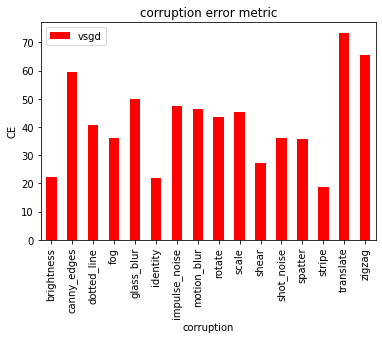

In [14]:
d = {
    'vsgd': corruption_errors,
}

pd.DataFrame(d).plot(kind='bar', color=['r', 'b'])
plt.ylabel('CE')
plt.xlabel('corruption')
plt.title("corruption error metric")
plt.savefig('./plots/mnist_corruption_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate Relative Corruption Errors (eq 3.2)

In [15]:

rce = ce.relative_corruption_error(v_model, base_model, corrupted_mnist_datasets, train_data, device)
print("Relative corruption errors: ")
pprint.pprint(rce)

mrce = ce.mean_corruption_error(rce)
print(f"\nMean relative corruption error: {mrce}")

  0%|          | 0/16 [00:00<?, ?it/s]

Finding relative corruption error for identity
Finding relative corruption error for shot_noise
Finding relative corruption error for impulse_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for motion_blur
Finding relative corruption error for shear
Finding relative corruption error for scale
Finding relative corruption error for rotate
Finding relative corruption error for brightness
Finding relative corruption error for translate
Finding relative corruption error for stripe
Finding relative corruption error for fog
Finding relative corruption error for spatter
Finding relative corruption error for dotted_line
Finding relative corruption error for zigzag
Finding relative corruption error for canny_edges
Relative corruption errors: 
{'brightness': 22.017802618640996,
 'canny_edges': 60.98607610130836,
 'dotted_line': 43.924330295498486,
 'fog': 36.34009587399418,
 'glass_blur': 52.35424456446476,
 'identity': 18.055555555555554,
 'impulse_noise'

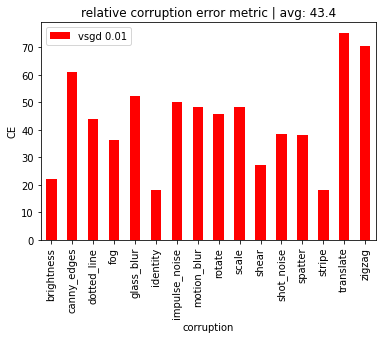

In [16]:
d = {
    'vsgd 0.01': rce,
}

pd.DataFrame(d).plot(kind='bar', color=['r', 'b'])
plt.ylabel('CE')
plt.xlabel('corruption')
plt.title(f"relative corruption error metric | avg: {mrce:.1f}")
plt.savefig('./plots/mnist_relative_corruption_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# Varying the variability

In [17]:
variabilities = [0.1, 0.0015, 0.002, 0.005, 0.01]

ces = {}
rces = {}

for var in variabilities:
    v_model = Conv1()
    v_optim = VSGD(v_model.parameters(), variability=var, lr=learning_rate, momentum=momentum)
    _, _ = train_mnist(v_model, v_optim, criterion, train_loader, device, batch_size=batch_size)
    vsgd_errors = ce.corruption_errors(v_model, corrupted_mnist_datasets, device)
    corruption_errors = {k: (vsgd_errors[k]/base_errors[k]) * 100 for k in vsgd_errors.keys() & base_errors}
    rce = ce.relative_corruption_error(v_model, base_model, corrupted_mnist_datasets, train_data, device)
    ces[var] = corruption_errors
    rces[var] = rce

  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Finding relative corruption error for identity
Finding relative corruption error for shot_noise
Finding relative corruption error for impulse_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for motion_blur
Finding relative corruption error for shear
Finding relative corruption error for scale
Finding relative corruption error for rotate
Finding relative corruption error for brightness
Finding relative corruption error for translate
Finding relative corruption error for stripe
Finding relative corruption error for fog
Finding relative corruption error for spatter
Finding relative corruption error for dotted_line
Finding relative corruption error for zigzag
Finding relative corruption error for canny_edges


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Finding relative corruption error for identity
Finding relative corruption error for shot_noise
Finding relative corruption error for impulse_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for motion_blur
Finding relative corruption error for shear
Finding relative corruption error for scale
Finding relative corruption error for rotate
Finding relative corruption error for brightness
Finding relative corruption error for translate
Finding relative corruption error for stripe
Finding relative corruption error for fog
Finding relative corruption error for spatter
Finding relative corruption error for dotted_line
Finding relative corruption error for zigzag
Finding relative corruption error for canny_edges


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Finding relative corruption error for identity
Finding relative corruption error for shot_noise
Finding relative corruption error for impulse_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for motion_blur
Finding relative corruption error for shear
Finding relative corruption error for scale
Finding relative corruption error for rotate
Finding relative corruption error for brightness
Finding relative corruption error for translate
Finding relative corruption error for stripe
Finding relative corruption error for fog
Finding relative corruption error for spatter
Finding relative corruption error for dotted_line
Finding relative corruption error for zigzag
Finding relative corruption error for canny_edges


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Finding relative corruption error for identity
Finding relative corruption error for shot_noise
Finding relative corruption error for impulse_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for motion_blur
Finding relative corruption error for shear
Finding relative corruption error for scale
Finding relative corruption error for rotate
Finding relative corruption error for brightness
Finding relative corruption error for translate
Finding relative corruption error for stripe
Finding relative corruption error for fog
Finding relative corruption error for spatter
Finding relative corruption error for dotted_line
Finding relative corruption error for zigzag
Finding relative corruption error for canny_edges


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Finding relative corruption error for identity
Finding relative corruption error for shot_noise
Finding relative corruption error for impulse_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for motion_blur
Finding relative corruption error for shear
Finding relative corruption error for scale
Finding relative corruption error for rotate
Finding relative corruption error for brightness
Finding relative corruption error for translate
Finding relative corruption error for stripe
Finding relative corruption error for fog
Finding relative corruption error for spatter
Finding relative corruption error for dotted_line
Finding relative corruption error for zigzag
Finding relative corruption error for canny_edges


Displaying corruption errors: 
& 647.8& 109.9& 128.8& 596.6& 368.4& 151.4& 330.2& 203.4& 490.6& 388.4& 355.1& 675.8& 608.9& 131.9& 277.7& 1363.4

& 24.0& 13.5& 71.1& 15.9& 29.8& 29.7& 34.7& 22.2& 35.3& 44.4& 13.5& 17.8& 30.6& 6.9& 12.7& 20.8

& 27.5& 29.9& 69.8& 28.4& 47.3& 69.0& 42.2& 25.8& 51.5& 56.7& 28.6& 23.9& 41.8& 18.6& 24.2& 29.1

& 21.6& 9.1& 67.9& 14.9& 34.3& 37.7& 21.3& 17.0& 49.8& 33.8& 11.5& 13.6& 22.2& 4.1& 12.5& 17.1

& 27.9& 11.1& 71.5& 16.1& 31.0& 47.0& 25.1& 27.1& 44.8& 39.5& 13.4& 17.8& 25.1& 2.6& 27.6& 18.2

Displaying relative corruption errors: 
516.6174709911642
& 2234.6& 804.3& 374.9& 345.5& 285.4& 705.9& 543.9& 414.9& 129.1& 125.9& 203.8& 106.8& 762.6& 688.5& 390.8& 149.1

24.788571198165474
& 11.0& 13.4& 10.9& 34.8& 10.7& 29.9& 35.5& 45.9& 5.7& 72.6& 21.4& 12.7& 21.5& 11.8& 29.2& 29.5

38.02618602404695
& 23.4& 20.4& 27.6& 42.8& 23.0& 43.0& 54.2& 59.5& 17.8& 71.2& 25.0& 29.6& 25.1& 26.5& 48.7& 70.6

23.54258475627144
& 10.4& 10.2& 9.7& 20.8& 11.2& 21.3& 54.1& 

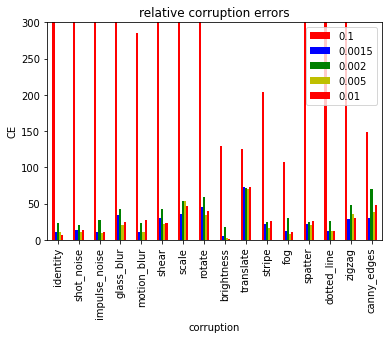

In [18]:
import pprint
import numpy as np
#pprint.pprint(rces)
#pprint.pprint(ces)

print("Displaying corruption errors: ")
for k, v in ces.items():
    for y in v.values():
        print(f"& {y:.1f}", end = '')
    print("\n")
    
print("Displaying relative corruption errors: ")
for k, v in rces.items():

    print(np.mean(list(v.values())))
    for y in v.values():
        print(f"& {y:.1f}", end = '')
    print("\n")
    
pd.DataFrame(rces).plot(kind='bar', color=['r', 'b', 'g', 'y'])
plt.ylabel('CE')
plt.xlabel('corruption')
plt.title(f"relative corruption errors")
plt.ylim(top=300) 
plt.savefig('./plots/mnist_relative_corruption_errors_vars.png', dpi=300, bbox_inches='tight')
plt.show()